In [1]:
import json
import xmltodict
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pymongo
import datetime

In [2]:
# connecting to mongo db
client = pymongo.MongoClient(port=27017)

# creating a db
db=client.task3b

In [3]:
def parse_data(path):

    file = open(path, 'r')
    i = 0

    num_lines = sum(1 for line in file)

    file.seek(0)

    # extracting tags from xml file and parsing them to JSON

    data = []

    for line in file:
        if i>1 and i<(num_lines-1):
            tmp = xmltodict.parse(line)
            tmp = tmp['row']
            obj = {}

            for item in tmp:
                obj[item[1:]] = tmp[item]
            data.append(obj)
        i+=1
        
    return data

In [4]:
# NOTE:
# You need to open jupyter-notebook, by changing the directory through terminal, inside the folder where this notebook is stored
# Otherwise, this program will throw an error while locating the xml files mentioned below

In [5]:
badges = parse_data('./stackoverflow.com/Badges.xml')
print("Successfully parsed Badges.xml")
# db.badges.insert_many(badges)
print("Successfully inserted the data in badges collection.")

Successfully parsed Badges.xml
Successfully inserted the data in badges collection.


In [6]:
tags = parse_data('./stackoverflow.com/Tags.xml')
print("Successfully parsed Tags.xml")
# db.tags.insert_many(tags)
print("Successfully inserted the data in tags collection.")

Successfully parsed Tags.xml
Successfully inserted the data in tags collection.


In [7]:
users = parse_data('./stackoverflow.com/Users.xml')
print("Successfully parsed Users.xml")
# db.users.insert_many(users)
print("Successfully inserted the data in users collection.")

Successfully parsed Users.xml
Successfully inserted the data in users collection.


In [8]:
votes = parse_data('./stackoverflow.com/Votes.xml')
print("Successfully parsed Votes.xml")
# db.votes.insert_many(votes)
print("Successfully inserted the data in votes collection.")

Successfully parsed Votes.xml
Successfully inserted the data in votes collection.


In [9]:
posts = parse_data('./stackoverflow.com/Posts.xml')
print("Successfully parsed Posts.xml")
# db.posts.insert_many(posts)
print("Successfully inserted the data in posts collection.")

Successfully parsed Posts.xml
Successfully inserted the data in posts collection.


In [10]:
# extracting tags in the form of lists, from string consisting of multiple tags

def get_tags_from_string(val):
    val = val.split("><")
    if len(val[0])>0:
        val[0] = val[0][1:]
        val[len(val)-1] = val[len(val)-1][:-1]
    return val

tags = {}

questions=0

for obj in posts:
    if obj['PostTypeId'] == '1':
        tag_list = get_tags_from_string(obj['Tags'])
        for tag in tag_list:
            if tag not in tags.keys():
                tags[tag] = 0
            tags[tag] += 1
        questions += 1

In [11]:
# sorting the dictionary based on frequency from maximum to minimum
tags = dict(sorted(tags.items(), key=lambda item: item[1], reverse=True))

# figuring out the criteria
print("Total number of questions present in posts.xml : {}.".format(questions))
most_tag = list(tags.keys())[0]
print("{} is the tag with maximum occurances which occurs in {} questions.".format(most_tag, tags[most_tag]))
if questions == tags[most_tag]:
    print("Since {} tag occurs in every question.".format(most_tag))
    print("Hence questions having {} tag is the criteria for subsampling.".format(most_tag))

Total number of questions present in posts.xml : 1358860.
python is the tag with maximum occurances which occurs in 1358860 questions.
Since python tag occurs in every question.
Hence questions having python tag is the criteria for subsampling.


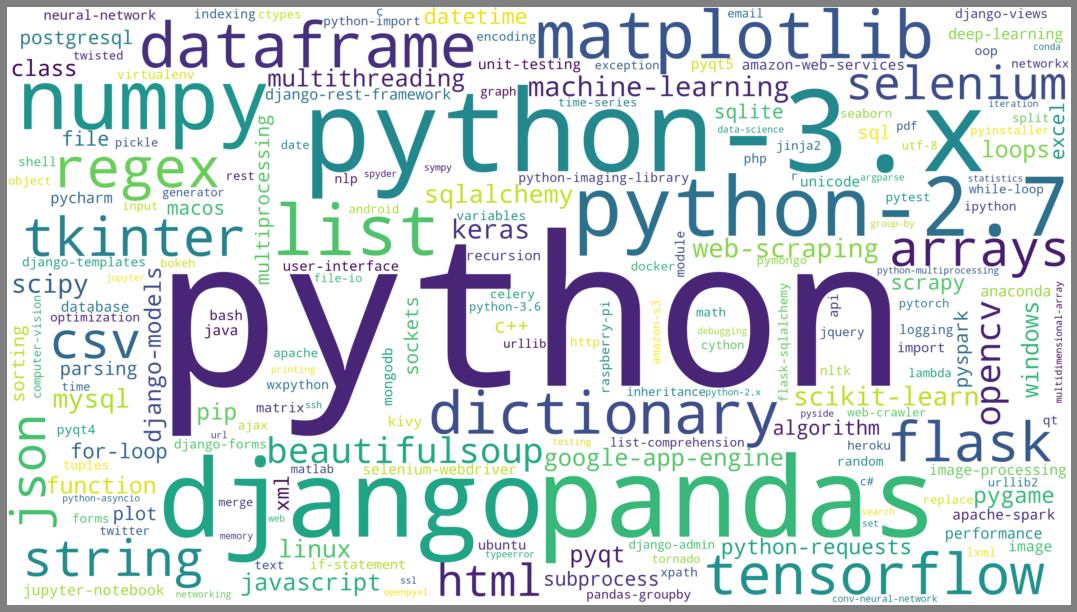

In [12]:
# Wordcloud of all tags

wordcloud = WordCloud(background_color='white', width=3840, height=2160)
wordcloud.generate_from_frequencies(frequencies=tags)

plt.figure(figsize=(20,11),  facecolor='grey')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

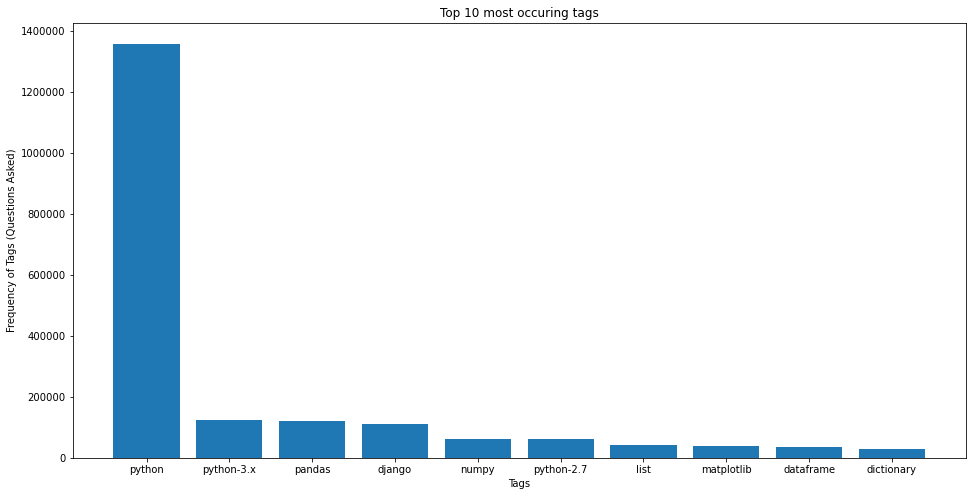

In [13]:
# Frequency of top 10 tags

top_tags = list(tags.keys())[:10]
top_tags_freq = list(tags.values())[:10]

plt.figure(figsize=(16, 8))
plt.bar(top_tags, top_tags_freq)
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Tags')
plt.ylabel('Frequency of Tags (Questions Asked)')
plt.title('Top 10 most occuring tags')
plt.show()

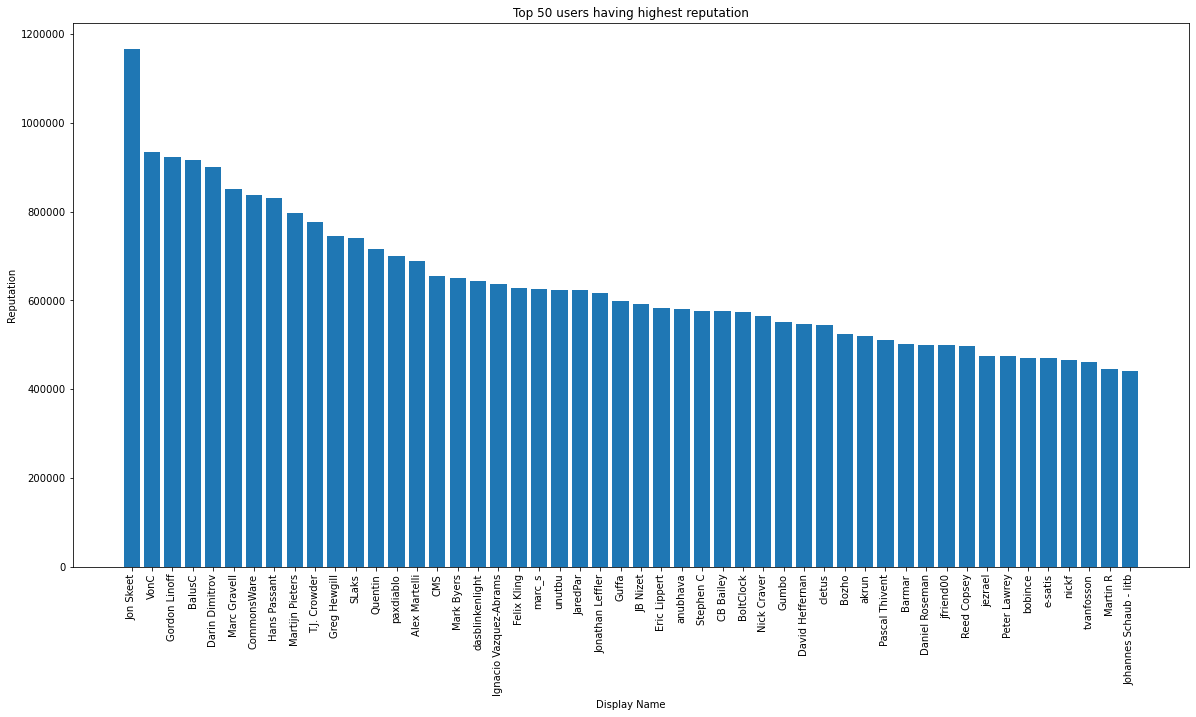

Jon Skeet [Id: 22656] is the most reputed user having a reputation of 1166685.


In [14]:
# Top 50 users having highest reputation

user_info = {}
for user in users:
    if user['Id'] not in user_info:
        user_info[user['Id']] = {"DisplayName":user['DisplayName'], "Reputation":int(user['Reputation'])}
        
labels = dict(sorted(user_info.items(), key=lambda item: item[1]['Reputation'], reverse=True))
values = [x['Reputation'] for x in labels.values()]
user_ids = list(labels.keys())
labels = [x['DisplayName'] for x in labels.values()]


fig = plt.figure(figsize =(20, 10))
plt.bar(labels[:50], values[:50])
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
plt.title('Top 50 users having highest reputation')
plt.xlabel('Display Name')
plt.ylabel('Reputation')
plt.show()

print("{} [Id: {}] is the most reputed user having a reputation of {}.".format(labels[0], user_ids[0], values[0]))

In [ ]:
# Top 20 questions

post_info = {}
for post in posts:
    if post['PostTypeId'] == '1':
        if post['Id'] not in post_info:
            post_info[post['Id']] = {"Score":int(post['Score']), "Title":post['Title'], "CreationDate": datetime.datetime.strptime(post['CreationDate'], '%Y-%m-%dT%H:%M:%S.%f')}

        
labels = dict(sorted(post_info.items(), key=lambda item: item[1]['Score'], reverse=True))
values = [x['Score'] for x in labels.values()]
labels = [x for x in labels.keys()]


fig = plt.figure(figsize =(20, 10))
plt.bar(labels[:20], values[:20])
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=90)
plt.title('Top 20 questions')
plt.xlabel('Question Id')
plt.ylabel('Score')
plt.show()

print("Top 20 questions are as follows: ")
for ques_id in labels[:20]:
    print("[Id: {}] : {}".format(ques_id, post_info[ques_id]["Title"]))


In [ ]:
# Count of posts (including both questions and answers) every month

post_time = {}
for post_id in post_info.keys():
    time_val = post_info[post_id]['CreationDate']
    time_val = time_val.replace(day=1, hour=0, minute=0, second=0, microsecond=0)
    if time_val not in post_time.keys():
        post_time[time_val]=0
    post_time[time_val]+=1

plt.figure(figsize=(20,10))
plt.gca().xaxis_date('Asia/Kolkata')
plt.plot(list(post_time.keys()),post_time.values(),  linestyle='-', marker='o')
plt.xlabel('Year (in IST)')
plt.ylabel('Posts Count')
plt.title('Count of posts posted every month')
plt.show()

print("From the trend it can be observed that posts on the website are growing every month.")
print("Since these posts are sampled on the basis of Python, and every month, more people are discussing about it.")
print("Thus, popularity of Python is increasing every month.")

In [ ]:
# upvotes/downvotes trends

vote_info = {'upvotes': 0, 'downvotes': 0}

for vote in votes:
    if vote['VoteTypeId'] == '2':
        vote_info['upvotes'] += 1
    elif vote['VoteTypeId'] == '3':
        vote_info['downvotes'] += 1
        
plt.figure(figsize =(10, 10)) 
plt.pie(list(vote_info.values()), labels = list(vote_info.keys()), autopct='%1.1f%%',shadow=True, startangle=90)
plt.legend(loc="upper right")
plt.title("Voting trends among all the posts")
plt.show()

print("Among all the posts, {:.2f}% are upvotes and {:.2f}% are downvotes.".format(vote_info['upvotes']*100/(vote_info['upvotes']+vote_info['downvotes']), vote_info['downvotes']*100/(vote_info['upvotes']+vote_info['downvotes'])))
if vote_info['upvotes'] >= vote_info['downvotes']:
      print("This concludes, that a majority of posts are correct, and community has a very positive response.")
else:
      print("This concludes, that a majority of posts are incorrect, and community has a very negative response.")

In [ ]:
# Developed by: Shlok Pandey (@b30wulffz)